# PSO-Optimized DistilBERT for Financial Sentiment Analysis
## STATS 507 Final Project

This notebook contains the complete implementation for fine-tuning DistilBERT on Financial PhraseBank with Particle Swarm Optimization for hyperparameter tuning.

## Cell 1: Install & Import Libraries

In [5]:
# Install required packages (uncomment and run once if needed)
# !pip install torch transformers datasets pandas numpy scikit-learn matplotlib seaborn pyswarms

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW  # FIXED: Import from torch.optim instead of transformers
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
import pyswarms as ps
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cpu')
print(f"Using device: {device}")
print("✓ All libraries imported successfully!")

Using device: cpu
✓ All libraries imported successfully!


## Cell 2: Load Financial PhraseBank Dataset

Loading Financial PhraseBank dataset...
✓ Loaded 2264 sentences

Label distribution:
label_text
neutral     1391
positive     570
negative     303
Name: count, dtype: int64


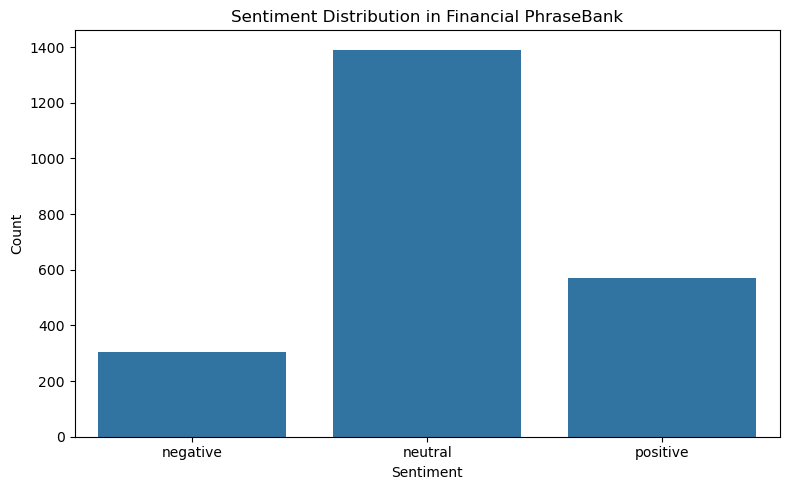


=== Example Sentences ===

NEGATIVE:
1. Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
2. Pharmaceuticals group Orion Corp reported a fall in its third-quarter earnings that were hit by larger expenditures on R&D and marketing .

NEUTRAL:
1. According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
2. At the request of Finnish media company Alma Media 's newspapers , research manager Jari Kaivo-oja at the Finland Futures Research Centre at the Turku School of Economics has drawn up a future scenario for Finland 's national economy by using a model developed by the University of Denver .

POSITIVE:
1. For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
2. In the third quarter of 2010 , net sales increased 

In [6]:
# Load Financial PhraseBank
print("Loading Financial PhraseBank dataset...")

# Update this path to where your file is located
file_path = '/Users/zhuwenxuan/Desktop/STAT 507/final project/data/FinancialPhraseBank-v1.0/Sentences_AllAgree.txt'  # or 'data/raw/Sentences_AllAgree.txt'

# Load with @ separator
df = pd.read_csv(file_path, sep='@', header=None, encoding='latin-1')
df.columns = ['sentence', 'label_text']

# Map to numeric labels
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['label'] = df['label_text'].map(label_map)

# Clean
df = df.dropna()
df['label'] = df['label'].astype(int)

print(f"✓ Loaded {len(df)} sentences")
print(f"\nLabel distribution:")
print(df['label_text'].value_counts())

# Visualize
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='label_text', order=['negative', 'neutral', 'positive'])
plt.title('Sentiment Distribution in Financial PhraseBank')
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.tight_layout()
plt.show()

# Show examples
print("\n=== Example Sentences ===")
for label_text in ['negative', 'neutral', 'positive']:
    print(f"\n{label_text.upper()}:")
    examples = df[df['label_text'] == label_text]['sentence'].head(2)
    for i, ex in enumerate(examples, 1):
        print(f"{i}. {ex}")

## Cell 3: Create PyTorch Dataset Class

In [7]:
class FinancialSentimentDataset(Dataset):
    """PyTorch Dataset for financial sentiment"""
    
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("✓ Dataset class created")

✓ Dataset class created


## Cell 4: Prepare & Split Data

In [8]:
# Split data
texts = df['sentence'].tolist()
labels = df['label'].tolist()

# Split: 70% train, 10% val, 20% test
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts, train_val_labels, test_size=0.125, random_state=42, stratify=train_val_labels
)

print("Dataset split:")
print(f"  Train: {len(train_texts)} samples")
print(f"  Val:   {len(val_texts)} samples")
print(f"  Test:  {len(test_texts)} samples")

# Load tokenizer
print("\nLoading tokenizer...")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Create datasets
print("Creating PyTorch datasets...")
train_dataset = FinancialSentimentDataset(train_texts, train_labels, tokenizer)
val_dataset = FinancialSentimentDataset(val_texts, val_labels, tokenizer)
test_dataset = FinancialSentimentDataset(test_texts, test_labels, tokenizer)

print("✓ Datasets ready!")

# Test one sample
sample = train_dataset[0]
print(f"\nSample check:")
print(f"  Input IDs shape: {sample['input_ids'].shape}")
print(f"  Attention mask shape: {sample['attention_mask'].shape}")
print(f"  Label: {sample['labels']}")

Dataset split:
  Train: 1584 samples
  Val:   227 samples
  Test:  453 samples

Loading tokenizer...
Creating PyTorch datasets...
✓ Datasets ready!

Sample check:
  Input IDs shape: torch.Size([128])
  Attention mask shape: torch.Size([128])
  Label: 1


## Cell 5: Training Functions

In [9]:
def train_epoch(model, dataloader, optimizer, scheduler, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    predictions = []
    true_labels = []
    
    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        predictions.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = np.mean(np.array(predictions) == np.array(true_labels))
    return avg_loss, accuracy

def evaluate(model, dataloader, device):
    """Evaluate on validation/test set"""
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            
            total_loss += outputs.loss.item()
            predictions.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = np.mean(np.array(predictions) == np.array(true_labels))
    return avg_loss, accuracy, predictions, true_labels

def train_model(model, train_dataloader, val_dataloader, optimizer, scheduler, 
                device, num_epochs, patience=3):
    """Full training loop with early stopping"""
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 50)
        
        train_loss, train_acc = train_epoch(model, train_dataloader, optimizer, scheduler, device)
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        
        val_loss, val_acc, _, _ = evaluate(model, val_dataloader, device)
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            print(f"✓ New best model!")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break
    
    if best_model_state:
        model.load_state_dict(best_model_state)
    
    return history

print("✓ Training functions defined")

✓ Training functions defined


## Cell 6: Train Baseline Model

This will take approximately 1-2 hours on CPU.

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TRAINING BASELINE MODEL

Starting training...

Epoch 1/10
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:50<00:00,  1.11s/it]


Train Loss: 0.6421, Train Acc: 0.7317


Evaluating: 100%|██████████| 15/15 [00:04<00:00,  3.65it/s]


Val Loss: 0.3143, Val Acc: 0.8722
✓ New best model!

Epoch 2/10
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:52<00:00,  1.14s/it]


Train Loss: 0.2678, Train Acc: 0.9141


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


Val Loss: 0.1893, Val Acc: 0.9383
✓ New best model!

Epoch 3/10
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:44<00:00,  1.06s/it]


Train Loss: 0.1256, Train Acc: 0.9634


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


Val Loss: 0.1428, Val Acc: 0.9559
✓ New best model!

Epoch 4/10
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:44<00:00,  1.06s/it]


Train Loss: 0.0907, Train Acc: 0.9779


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.77it/s]


Val Loss: 0.0608, Val Acc: 0.9736
✓ New best model!

Epoch 5/10
--------------------------------------------------


Training: 100%|██████████| 99/99 [13:39<00:00,  8.27s/it]   


Train Loss: 0.0526, Train Acc: 0.9842


Evaluating: 100%|██████████| 15/15 [00:04<00:00,  3.71it/s]


Val Loss: 0.0842, Val Acc: 0.9736

Epoch 6/10
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:46<00:00,  1.08s/it]


Train Loss: 0.0350, Train Acc: 0.9893


Evaluating: 100%|██████████| 15/15 [00:04<00:00,  3.67it/s]


Val Loss: 0.0821, Val Acc: 0.9780

Epoch 7/10
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:47<00:00,  1.08s/it]


Train Loss: 0.0272, Train Acc: 0.9912


Evaluating: 100%|██████████| 15/15 [00:04<00:00,  3.54it/s]


Val Loss: 0.0871, Val Acc: 0.9780
Early stopping at epoch 7

BASELINE MODEL - TEST EVALUATION


Evaluating: 100%|██████████| 29/29 [08:22<00:00, 17.31s/it] 


Test Accuracy: 95.14%
Test Loss: 0.2094


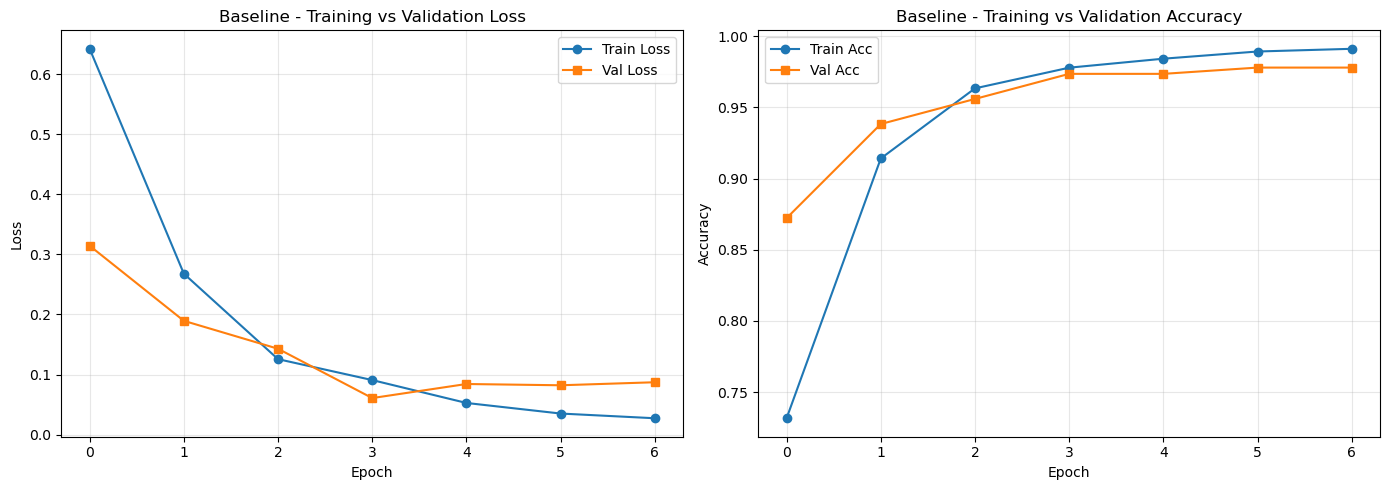


✓ Baseline model training complete!


In [11]:
print("="*60)
print("TRAINING BASELINE MODEL")
print("="*60)

# Hyperparameters
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_EPOCHS = 10
DROPOUT_RATE = 0.3

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Initialize model
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3,
    dropout=DROPOUT_RATE
)
model.to(device)

# Optimizer & scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * NUM_EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, 0, total_steps)

# Train
print("\nStarting training...")
history = train_model(model, train_loader, val_loader, optimizer, scheduler, 
                     device, NUM_EPOCHS, patience=3)

# Evaluate on test
print("\n" + "="*60)
print("BASELINE MODEL - TEST EVALUATION")
print("="*60)
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, device)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Save baseline results
baseline_results = {
    'test_accuracy': test_acc,
    'test_loss': test_loss,
    'test_predictions': test_preds,
    'test_labels': test_labels,
    'history': history,
    'hyperparameters': {
        'learning_rate': LEARNING_RATE,
        'dropout_rate': DROPOUT_RATE,
        'batch_size': BATCH_SIZE
    }
}

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Baseline - Training vs Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history['train_acc'], label='Train Acc', marker='o')
ax2.plot(history['val_acc'], label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Baseline - Training vs Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Baseline model training complete!")

## Cell 7: PSO Hyperparameter Optimizer

In [14]:
class HyperparameterOptimizer:
    """PSO-based hyperparameter optimizer"""
    
    def __init__(self, train_dataset, val_dataset, device, n_particles=20, n_iterations=30):
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.device = device
        self.n_particles = n_particles
        self.n_iterations = n_iterations
        self.evaluation_history = []
        self.best_params = None
        self.best_accuracy = 0
    
    def decode_hyperparameters(self, particle):
        """Convert particle to hyperparameters"""
        return {
            'learning_rate': particle[0],
            'dropout_rate': particle[1],
            'hidden_size': int(particle[2])
        }
    
    def objective_function(self, particles):
        """Evaluate fitness for all particles"""
        n_particles = particles.shape[0]
        fitness = np.zeros(n_particles)
        
        for i, particle in enumerate(particles):
            print(f"\nParticle {i+1}/{n_particles}: {particle}")
            params = self.decode_hyperparameters(particle)
            print(f"  LR={params['learning_rate']:.2e}, Dropout={params['dropout_rate']:.3f}, Hidden={params['hidden_size']}")
            
            val_acc = self._train_and_evaluate(params)
            
            self.evaluation_history.append({
                'particle': particle.tolist(),
                'hyperparameters': params,
                'val_accuracy': val_acc,
                'timestamp': datetime.now()
            })
            
            if val_acc > self.best_accuracy:
                self.best_accuracy = val_acc
                self.best_params = params
                print(f"  ✓ New best! Accuracy: {val_acc:.4f}")
            
            fitness[i] = -val_acc  # Negative because PSO minimizes
        
        return fitness
    
    def _train_and_evaluate(self, params):
        """Train model with given hyperparameters"""
        batch_size = 16
        train_loader = DataLoader(self.train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(self.val_dataset, batch_size=batch_size)
        
        model = DistilBertForSequenceClassification.from_pretrained(
            'distilbert-base-uncased',
            num_labels=3,
            dropout=params['dropout_rate']
        )
        model.to(self.device)
        
        optimizer = AdamW(model.parameters(), lr=params['learning_rate'])
        total_steps = len(train_loader) * 5
        scheduler = get_linear_schedule_with_warmup(optimizer, 0, total_steps)
        
        history = train_model(model, train_loader, val_loader, optimizer, scheduler,
                            self.device, num_epochs=5, patience=2)
        
        best_val_acc = max(history['val_acc'])
        
        del model
        
        return best_val_acc
    
    def optimize(self):
        """Run PSO optimization"""
        print("="*60)
        print("STARTING PSO HYPERPARAMETER OPTIMIZATION")
        print("="*60)
        print(f"Particles: {self.n_particles}")
        print(f"Iterations: {self.n_iterations}")
        print(f"Total evaluations: {self.n_particles * self.n_iterations}")
        
        # Search space: [learning_rate, dropout_rate, hidden_size]
        min_bounds = np.array([1e-5, 0.2, 64])
        max_bounds = np.array([1e-3, 0.5, 512])
        bounds = (min_bounds, max_bounds)
        
        options = {'c1': 2.0, 'c2': 2.0, 'w': 0.9}
        
        optimizer = ps.single.GlobalBestPSO(
            n_particles=self.n_particles,
            dimensions=3,
            options=options,
            bounds=bounds
        )
        
        cost, pos = optimizer.optimize(self.objective_function, iters=self.n_iterations, verbose=True)
        
        print("\n" + "="*60)
        print("OPTIMIZATION COMPLETE")
        print(f"Best Accuracy: {self.best_accuracy:.4f}")
        print("Best Hyperparameters:")
        for key, value in self.best_params.items():
            print(f"  {key}: {value}")
        print("="*60)
        
        return self.best_params, self.best_accuracy

print("✓ PSO Optimizer class defined")

✓ PSO Optimizer class defined


## Cell 8: Run PSO Optimization

⚠️ **WARNING: This takes 8-12 hours on CPU with full settings!**

**For TESTING:** Use `n_particles=5, n_iterations=3` (takes ~15 minutes)

**For FINAL RUN:** Use `n_particles=20, n_iterations=30` (takes ~10 hours)

In [15]:
print("Initializing PSO optimizer...")
pso_optimizer = HyperparameterOptimizer(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    device=device,
    n_particles=5,     # ← Change to 20 for final run
    n_iterations=3     # ← Change to 30 for final run
)

print("\n⚠️  Starting PSO optimization...")
print("    This will take a long time!")
print("    Test run (5 particles, 3 iterations): ~15 minutes")
print("    Full run (20 particles, 30 iterations): ~10 hours\n")

best_params, best_acc = pso_optimizer.optimize()

# Save PSO results
pso_results = {
    'best_params': best_params,
    'best_accuracy': best_acc,
    'evaluation_history': pso_optimizer.evaluation_history,
    'n_particles': pso_optimizer.n_particles,
    'n_iterations': pso_optimizer.n_iterations
}

print("\n✓ PSO optimization complete!")
print(f"Best parameters: {best_params}")
print(f"Best validation accuracy: {best_acc*100:.2f}%")

2025-11-14 22:35:52,508 - pyswarms.single.global_best - INFO - Optimize for 3 iters with {'c1': 2.0, 'c2': 2.0, 'w': 0.9}


Initializing PSO optimizer...

⚠️  Starting PSO optimization...
    This will take a long time!
    Test run (5 particles, 3 iterations): ~15 minutes
    Full run (20 particles, 30 iterations): ~10 hours

STARTING PSO HYPERPARAMETER OPTIMIZATION
Particles: 5
Iterations: 3
Total evaluations: 15


pyswarms.single.global_best:   0%|          |0/3Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Particle 1/5: [1.28398303e-04 4.13973436e-01 4.04831702e+02]
  LR=1.28e-04, Dropout=0.414, Hidden=404

Epoch 1/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:47<00:00,  1.09s/it]


Train Loss: 0.5056, Train Acc: 0.8011


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


Val Loss: 0.1661, Val Acc: 0.9604
✓ New best model!

Epoch 2/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:47<00:00,  1.09s/it]


Train Loss: 0.1948, Train Acc: 0.9388


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.81it/s]


Val Loss: 0.0946, Val Acc: 0.9780
✓ New best model!

Epoch 3/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:44<00:00,  1.06s/it]


Train Loss: 0.1078, Train Acc: 0.9691


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


Val Loss: 0.1481, Val Acc: 0.9648

Epoch 4/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:45<00:00,  1.06s/it]


Train Loss: 0.0624, Train Acc: 0.9830


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


Val Loss: 0.2111, Val Acc: 0.9515
Early stopping at epoch 4
  ✓ New best! Accuracy: 0.9780

Particle 2/5: [5.65664426e-04 4.31290154e-01 2.85220427e+02]
  LR=5.66e-04, Dropout=0.431, Hidden=285


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:46<00:00,  1.08s/it]


Train Loss: 0.8555, Train Acc: 0.6566


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.89it/s]


Val Loss: 0.9125, Val Acc: 0.6167
✓ New best model!

Epoch 2/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:43<00:00,  1.05s/it]


Train Loss: 0.9307, Train Acc: 0.6193


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


Val Loss: 0.6760, Val Acc: 0.7489
✓ New best model!

Epoch 3/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:44<00:00,  1.06s/it]


Train Loss: 0.8783, Train Acc: 0.6263


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.85it/s]


Val Loss: 0.9020, Val Acc: 0.6167

Epoch 4/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:43<00:00,  1.05s/it]


Train Loss: 0.7426, Train Acc: 0.6862


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.76it/s]


Val Loss: 0.6363, Val Acc: 0.7577
✓ New best model!

Epoch 5/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:46<00:00,  1.07s/it]


Train Loss: 0.6342, Train Acc: 0.7412


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.78it/s]


Val Loss: 0.6086, Val Acc: 0.7181
✓ New best model!

Particle 3/5: [5.27505501e-04 3.28262306e-01 7.53877688e+01]
  LR=5.28e-04, Dropout=0.328, Hidden=75


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:47<00:00,  1.09s/it]


Train Loss: 0.7585, Train Acc: 0.6705


Evaluating: 100%|██████████| 15/15 [00:04<00:00,  3.20it/s]


Val Loss: 0.7566, Val Acc: 0.6167
✓ New best model!

Epoch 2/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:45<00:00,  1.07s/it]


Train Loss: 0.8226, Train Acc: 0.6338


Evaluating: 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]


Val Loss: 0.9579, Val Acc: 0.6167

Epoch 3/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:47<00:00,  1.09s/it]


Train Loss: 0.9249, Train Acc: 0.6143


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


Val Loss: 0.9255, Val Acc: 0.6167
Early stopping at epoch 3

Particle 4/5: [1.16812513e-04 2.09428756e-01 3.49111864e+02]
  LR=1.17e-04, Dropout=0.209, Hidden=349


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:55<00:00,  1.17s/it]


Train Loss: 0.4145, Train Acc: 0.8346


Evaluating: 100%|██████████| 15/15 [00:04<00:00,  3.64it/s]


Val Loss: 0.1925, Val Acc: 0.9515
✓ New best model!

Epoch 2/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:50<00:00,  1.11s/it]


Train Loss: 0.1440, Train Acc: 0.9621


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.79it/s]


Val Loss: 0.1245, Val Acc: 0.9736
✓ New best model!

Epoch 3/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:45<00:00,  1.06s/it]


Train Loss: 0.0798, Train Acc: 0.9754


Evaluating: 100%|██████████| 15/15 [00:04<00:00,  3.56it/s]


Val Loss: 0.1173, Val Acc: 0.9559
✓ New best model!

Epoch 4/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [02:26<00:00,  1.48s/it]


Train Loss: 0.0385, Train Acc: 0.9880


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


Val Loss: 0.1251, Val Acc: 0.9692

Epoch 5/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:37<00:00,  1.02it/s]


Train Loss: 0.0108, Train Acc: 0.9968


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


Val Loss: 0.1056, Val Acc: 0.9780
✓ New best model!

Particle 5/5: [3.21212421e-04 3.52571207e-01 4.70589780e+02]
  LR=3.21e-04, Dropout=0.353, Hidden=470


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:38<00:00,  1.01it/s]


Train Loss: 0.6759, Train Acc: 0.7393


Evaluating: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


Val Loss: 0.4626, Val Acc: 0.7269
✓ New best model!

Epoch 2/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:39<00:00,  1.01s/it]


Train Loss: 0.5231, Train Acc: 0.8037


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


Val Loss: 0.4574, Val Acc: 0.7841
✓ New best model!

Epoch 3/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:38<00:00,  1.01it/s]


Train Loss: 0.4570, Train Acc: 0.8245


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.08it/s]


Val Loss: 0.4180, Val Acc: 0.8238
✓ New best model!

Epoch 4/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:34<00:00,  1.05it/s]


Train Loss: 0.3996, Train Acc: 0.8258


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.12it/s]


Val Loss: 0.4807, Val Acc: 0.8106

Epoch 5/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:37<00:00,  1.01it/s]


Train Loss: 0.2558, Train Acc: 0.9173


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.12it/s]
pyswarms.single.global_best:  33%|███▎      |1/3, best_cost=-0.978

Val Loss: 0.2793, Val Acc: 0.9163
✓ New best model!

Particle 1/5: [7.51404537e-04 4.83318067e-01 4.05511698e+02]
  LR=7.51e-04, Dropout=0.483, Hidden=405


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:37<00:00,  1.02it/s]


Train Loss: 0.8754, Train Acc: 0.6313


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


Val Loss: 0.6428, Val Acc: 0.7533
✓ New best model!

Epoch 2/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:40<00:00,  1.02s/it]


Train Loss: 0.7704, Train Acc: 0.6926


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


Val Loss: 0.6000, Val Acc: 0.7577
✓ New best model!

Epoch 3/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:36<00:00,  1.03it/s]


Train Loss: 0.7302, Train Acc: 0.6705


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


Val Loss: 0.7129, Val Acc: 0.6167

Epoch 4/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [03:37<00:00,  2.19s/it]


Train Loss: 0.7547, Train Acc: 0.6553


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.82it/s]


Val Loss: 0.6396, Val Acc: 0.7225
Early stopping at epoch 4

Particle 2/5: [2.46007556e-04 4.66915921e-01 6.77202989e+01]
  LR=2.46e-04, Dropout=0.467, Hidden=67


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [25:15<00:00, 15.30s/it]


Train Loss: 0.6216, Train Acc: 0.7336


Evaluating: 100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


Val Loss: 0.3968, Val Acc: 0.8018
✓ New best model!

Epoch 2/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [20:20<00:00, 12.33s/it]


Train Loss: 0.3645, Train Acc: 0.8662


Evaluating: 100%|██████████| 15/15 [00:05<00:00,  2.79it/s]


Val Loss: 0.2353, Val Acc: 0.9295
✓ New best model!

Epoch 3/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:40<00:00,  1.01s/it]


Train Loss: 0.2124, Train Acc: 0.9419


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


Val Loss: 0.2536, Val Acc: 0.9427

Epoch 4/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:40<00:00,  1.02s/it]


Train Loss: 0.1755, Train Acc: 0.9577


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.86it/s]


Val Loss: 0.1922, Val Acc: 0.9427
✓ New best model!

Epoch 5/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:35<00:00,  1.04it/s]


Train Loss: 0.1060, Train Acc: 0.9716


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


Val Loss: 0.2006, Val Acc: 0.9559

Particle 3/5: [8.85687777e-04 3.50229656e-01 2.74360145e+02]
  LR=8.86e-04, Dropout=0.350, Hidden=274


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:39<00:00,  1.00s/it]


Train Loss: 0.9508, Train Acc: 0.5960


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


Val Loss: 0.9067, Val Acc: 0.6167
✓ New best model!

Epoch 2/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:42<00:00,  1.04s/it]


Train Loss: 0.9317, Train Acc: 0.6143


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


Val Loss: 0.9149, Val Acc: 0.6167

Epoch 3/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:43<00:00,  1.05s/it]


Train Loss: 0.9252, Train Acc: 0.6143


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.80it/s]


Val Loss: 0.9095, Val Acc: 0.6167
Early stopping at epoch 3

Particle 4/5: [9.36793577e-04 4.08833345e-01 4.17764820e+02]
  LR=9.37e-04, Dropout=0.409, Hidden=417


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:56<00:00,  1.18s/it]


Train Loss: 0.9601, Train Acc: 0.5966


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.75it/s]


Val Loss: 0.9421, Val Acc: 0.6167
✓ New best model!

Epoch 2/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:40<00:00,  1.01s/it]


Train Loss: 0.9356, Train Acc: 0.6130


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


Val Loss: 0.9674, Val Acc: 0.6167

Epoch 3/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:41<00:00,  1.03s/it]


Train Loss: 0.9270, Train Acc: 0.6143


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.99it/s]


Val Loss: 0.9176, Val Acc: 0.6167
✓ New best model!

Epoch 4/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:38<00:00,  1.00it/s]


Train Loss: 0.9296, Train Acc: 0.6143


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.05it/s]


Val Loss: 0.9063, Val Acc: 0.6167
✓ New best model!

Epoch 5/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:34<00:00,  1.04it/s]


Train Loss: 0.9198, Train Acc: 0.6143


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


Val Loss: 0.9224, Val Acc: 0.6167

Particle 5/5: [7.30418194e-04 2.62196126e-01 4.34428676e+02]
  LR=7.30e-04, Dropout=0.262, Hidden=434


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:36<00:00,  1.03it/s]


Train Loss: 0.9546, Train Acc: 0.5846


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


Val Loss: 0.9401, Val Acc: 0.6167
✓ New best model!

Epoch 2/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:36<00:00,  1.03it/s]


Train Loss: 0.9338, Train Acc: 0.6143


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.16it/s]


Val Loss: 0.9111, Val Acc: 0.6167
✓ New best model!

Epoch 3/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:35<00:00,  1.04it/s]


Train Loss: 0.9260, Train Acc: 0.6143


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


Val Loss: 0.9192, Val Acc: 0.6167

Epoch 4/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:38<00:00,  1.01it/s]


Train Loss: 0.9239, Train Acc: 0.6143


Evaluating: 100%|██████████| 15/15 [00:04<00:00,  3.50it/s]


Val Loss: 0.9109, Val Acc: 0.6167
✓ New best model!

Epoch 5/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:56<00:00,  1.17s/it]


Train Loss: 0.9215, Train Acc: 0.6143


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.14it/s]
pyswarms.single.global_best:  67%|██████▋   |2/3, best_cost=-0.978

Val Loss: 0.9062, Val Acc: 0.6167
✓ New best model!

Particle 1/5: [5.25602206e-04 4.38014823e-01 4.05672975e+02]
  LR=5.26e-04, Dropout=0.438, Hidden=405


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:35<00:00,  1.03it/s]


Train Loss: 0.8927, Train Acc: 0.6338


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.22it/s]


Val Loss: 0.9332, Val Acc: 0.6167
✓ New best model!

Epoch 2/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:35<00:00,  1.03it/s]


Train Loss: 0.9289, Train Acc: 0.6098


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


Val Loss: 0.9070, Val Acc: 0.6167
✓ New best model!

Epoch 3/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:36<00:00,  1.03it/s]


Train Loss: 0.9334, Train Acc: 0.6143


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


Val Loss: 0.9083, Val Acc: 0.6167

Epoch 4/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:41<00:00,  1.03s/it]


Train Loss: 0.9241, Train Acc: 0.6143


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.10it/s]


Val Loss: 0.9380, Val Acc: 0.6167
Early stopping at epoch 4

Particle 2/5: [1.46725305e-04 4.36412430e-01 2.83999529e+02]
  LR=1.47e-04, Dropout=0.436, Hidden=283


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:37<00:00,  1.01it/s]


Train Loss: 0.5706, Train Acc: 0.7588


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.07it/s]


Val Loss: 0.3094, Val Acc: 0.8502
✓ New best model!

Epoch 2/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:35<00:00,  1.03it/s]


Train Loss: 0.3171, Train Acc: 0.8908


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


Val Loss: 0.2233, Val Acc: 0.9383
✓ New best model!

Epoch 3/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:34<00:00,  1.04it/s]


Train Loss: 0.1784, Train Acc: 0.9527


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


Val Loss: 0.2415, Val Acc: 0.9251

Epoch 4/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:35<00:00,  1.03it/s]


Train Loss: 0.1193, Train Acc: 0.9634


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


Val Loss: 0.2158, Val Acc: 0.9295
✓ New best model!

Epoch 5/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:35<00:00,  1.04it/s]


Train Loss: 0.0795, Train Acc: 0.9773


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


Val Loss: 0.1672, Val Acc: 0.9604
✓ New best model!

Particle 3/5: [1.07434169e-04 3.11824236e-01 4.17971182e+02]
  LR=1.07e-04, Dropout=0.312, Hidden=417


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:33<00:00,  1.06it/s]


Train Loss: 0.4683, Train Acc: 0.8112


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.02it/s]


Val Loss: 0.2116, Val Acc: 0.9515
✓ New best model!

Epoch 2/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:34<00:00,  1.05it/s]


Train Loss: 0.1646, Train Acc: 0.9558


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


Val Loss: 0.1356, Val Acc: 0.9648
✓ New best model!

Epoch 3/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:33<00:00,  1.06it/s]


Train Loss: 0.0877, Train Acc: 0.9773


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.11it/s]


Val Loss: 0.1061, Val Acc: 0.9824
✓ New best model!

Epoch 4/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:35<00:00,  1.04it/s]


Train Loss: 0.0401, Train Acc: 0.9880


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.09it/s]


Val Loss: 0.1000, Val Acc: 0.9780
✓ New best model!

Epoch 5/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:36<00:00,  1.03it/s]


Train Loss: 0.0291, Train Acc: 0.9937


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


Val Loss: 0.0880, Val Acc: 0.9780
✓ New best model!
  ✓ New best! Accuracy: 0.9824

Particle 4/5: [9.22420033e-04 3.83414705e-01 3.74861193e+02]
  LR=9.22e-04, Dropout=0.383, Hidden=374


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:35<00:00,  1.03it/s]


Train Loss: 0.9682, Train Acc: 0.5934


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


Val Loss: 0.9196, Val Acc: 0.6167
✓ New best model!

Epoch 2/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:35<00:00,  1.04it/s]


Train Loss: 0.9376, Train Acc: 0.6124


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.04it/s]


Val Loss: 0.9230, Val Acc: 0.6167

Epoch 3/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:35<00:00,  1.04it/s]


Train Loss: 0.9250, Train Acc: 0.6143


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.84it/s]


Val Loss: 0.9121, Val Acc: 0.6167
✓ New best model!

Epoch 4/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:35<00:00,  1.04it/s]


Train Loss: 0.9205, Train Acc: 0.6143


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.00it/s]


Val Loss: 0.9241, Val Acc: 0.6167

Epoch 5/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:35<00:00,  1.04it/s]


Train Loss: 0.9236, Train Acc: 0.6143


Evaluating: 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]


Val Loss: 0.9147, Val Acc: 0.6167
Early stopping at epoch 5

Particle 5/5: [2.13570618e-04 4.72048630e-01 4.00273230e+02]
  LR=2.14e-04, Dropout=0.472, Hidden=400


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:35<00:00,  1.04it/s]


Train Loss: 0.6853, Train Acc: 0.7140


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


Val Loss: 0.3916, Val Acc: 0.8194
✓ New best model!

Epoch 2/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:33<00:00,  1.05it/s]


Train Loss: 0.4397, Train Acc: 0.8150


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.13it/s]


Val Loss: 0.4491, Val Acc: 0.7621

Epoch 3/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:34<00:00,  1.05it/s]


Train Loss: 0.3649, Train Acc: 0.8548


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


Val Loss: 0.3288, Val Acc: 0.8987
✓ New best model!

Epoch 4/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:34<00:00,  1.05it/s]


Train Loss: 0.2660, Train Acc: 0.9230


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.90it/s]


Val Loss: 0.2475, Val Acc: 0.9295
✓ New best model!

Epoch 5/5
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:36<00:00,  1.03it/s]


Train Loss: 0.1801, Train Acc: 0.9501


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.04it/s]
pyswarms.single.global_best: 100%|██████████|3/3, best_cost=-0.982
2025-11-15 01:19:12,235 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.9823788546255506, best pos: [1.07434169e-04 3.11824236e-01 4.17971182e+02]


Val Loss: 0.2514, Val Acc: 0.9339

OPTIMIZATION COMPLETE
Best Accuracy: 0.9824
Best Hyperparameters:
  learning_rate: 0.00010743416851210095
  dropout_rate: 0.3118242360891558
  hidden_size: 417

✓ PSO optimization complete!
Best parameters: {'learning_rate': np.float64(0.00010743416851210095), 'dropout_rate': np.float64(0.3118242360891558), 'hidden_size': 417}
Best validation accuracy: 98.24%


## Cell 9: Train Final Model with Optimal Hyperparameters

This will take approximately 1-2 hours on CPU.

In [16]:
print("="*60)
print("TRAINING FINAL MODEL WITH PSO-OPTIMIZED HYPERPARAMETERS")
print("="*60)

print(f"Optimal hyperparameters:")
print(f"  Learning Rate: {best_params['learning_rate']:.2e}")
print(f"  Dropout Rate: {best_params['dropout_rate']:.3f}")
print(f"  Hidden Size: {best_params['hidden_size']}")

# Create dataloaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Initialize model with optimal hyperparameters
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3,
    dropout=best_params['dropout_rate']
)
model.to(device)

# Optimizer & scheduler
optimizer = AdamW(model.parameters(), lr=best_params['learning_rate'])
total_steps = len(train_loader) * 10
scheduler = get_linear_schedule_with_warmup(optimizer, 0, total_steps)

# Train
print("\nStarting training...")
final_history = train_model(model, train_loader, val_loader, optimizer, scheduler,
                           device, num_epochs=10, patience=3)

# Test evaluation
print("\n" + "="*60)
print("FINAL MODEL - TEST EVALUATION")
print("="*60)
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, device)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Save final results
final_results = {
    'test_accuracy': test_acc,
    'test_loss': test_loss,
    'test_predictions': test_preds,
    'test_labels': test_labels,
    'history': final_history,
    'hyperparameters': best_params
}

print("\n✓ Final model training complete!")

TRAINING FINAL MODEL WITH PSO-OPTIMIZED HYPERPARAMETERS
Optimal hyperparameters:
  Learning Rate: 1.07e-04
  Dropout Rate: 0.312
  Hidden Size: 417


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting training...

Epoch 1/10
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:46<00:00,  1.08s/it]


Train Loss: 0.4482, Train Acc: 0.8188


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.83it/s]


Val Loss: 0.1754, Val Acc: 0.9295
✓ New best model!

Epoch 2/10
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:38<00:00,  1.01it/s]


Train Loss: 0.1788, Train Acc: 0.9381


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.01it/s]


Val Loss: 0.1704, Val Acc: 0.9471
✓ New best model!

Epoch 3/10
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:36<00:00,  1.02it/s]


Train Loss: 0.1050, Train Acc: 0.9729


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.92it/s]


Val Loss: 0.0916, Val Acc: 0.9780
✓ New best model!

Epoch 4/10
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:37<00:00,  1.02it/s]


Train Loss: 0.0629, Train Acc: 0.9811


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  4.06it/s]


Val Loss: 0.0965, Val Acc: 0.9780

Epoch 5/10
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:37<00:00,  1.02it/s]


Train Loss: 0.0456, Train Acc: 0.9880


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.97it/s]


Val Loss: 0.0952, Val Acc: 0.9780

Epoch 6/10
--------------------------------------------------


Training: 100%|██████████| 99/99 [01:37<00:00,  1.02it/s]


Train Loss: 0.0200, Train Acc: 0.9931


Evaluating: 100%|██████████| 15/15 [00:03<00:00,  3.95it/s]


Val Loss: 0.0989, Val Acc: 0.9868
Early stopping at epoch 6

FINAL MODEL - TEST EVALUATION


Evaluating: 100%|██████████| 29/29 [00:07<00:00,  3.79it/s]

Test Accuracy: 96.03%
Test Loss: 0.2417

✓ Final model training complete!


## Cell 10: Comprehensive Evaluation & Visualization

COMPREHENSIVE EVALUATION

TABLE I: OPTIMAL HYPERPARAMETERS FOUND BY PSO
Learning Rate Dropout Rate  Hidden Layer Size
     1.07e-04       0.3118                417


TABLE II: PERFORMANCE COMPARISON
              Model  Test Accuracy (%)  Test Loss
DistilBERT Baseline          95.143488   0.209429
   DistilBERT + PSO          96.026490   0.241659

Improvement: +0.88 percentage points


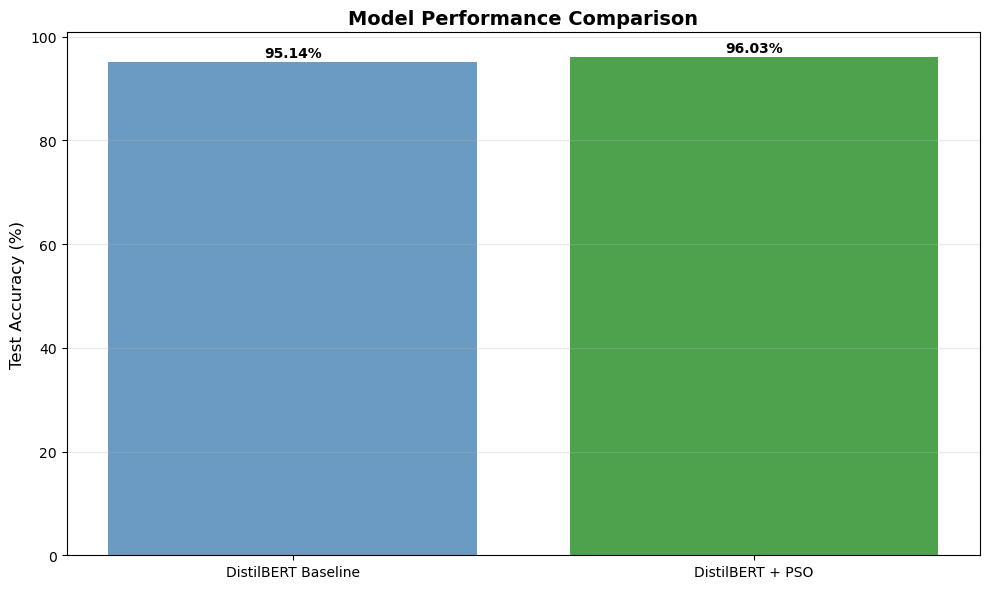

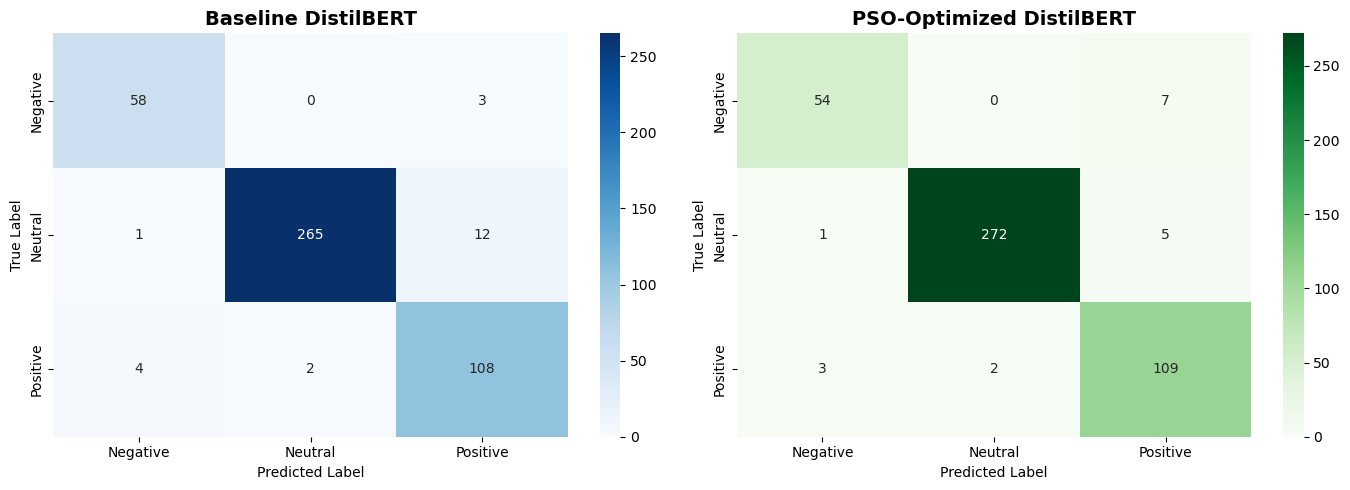

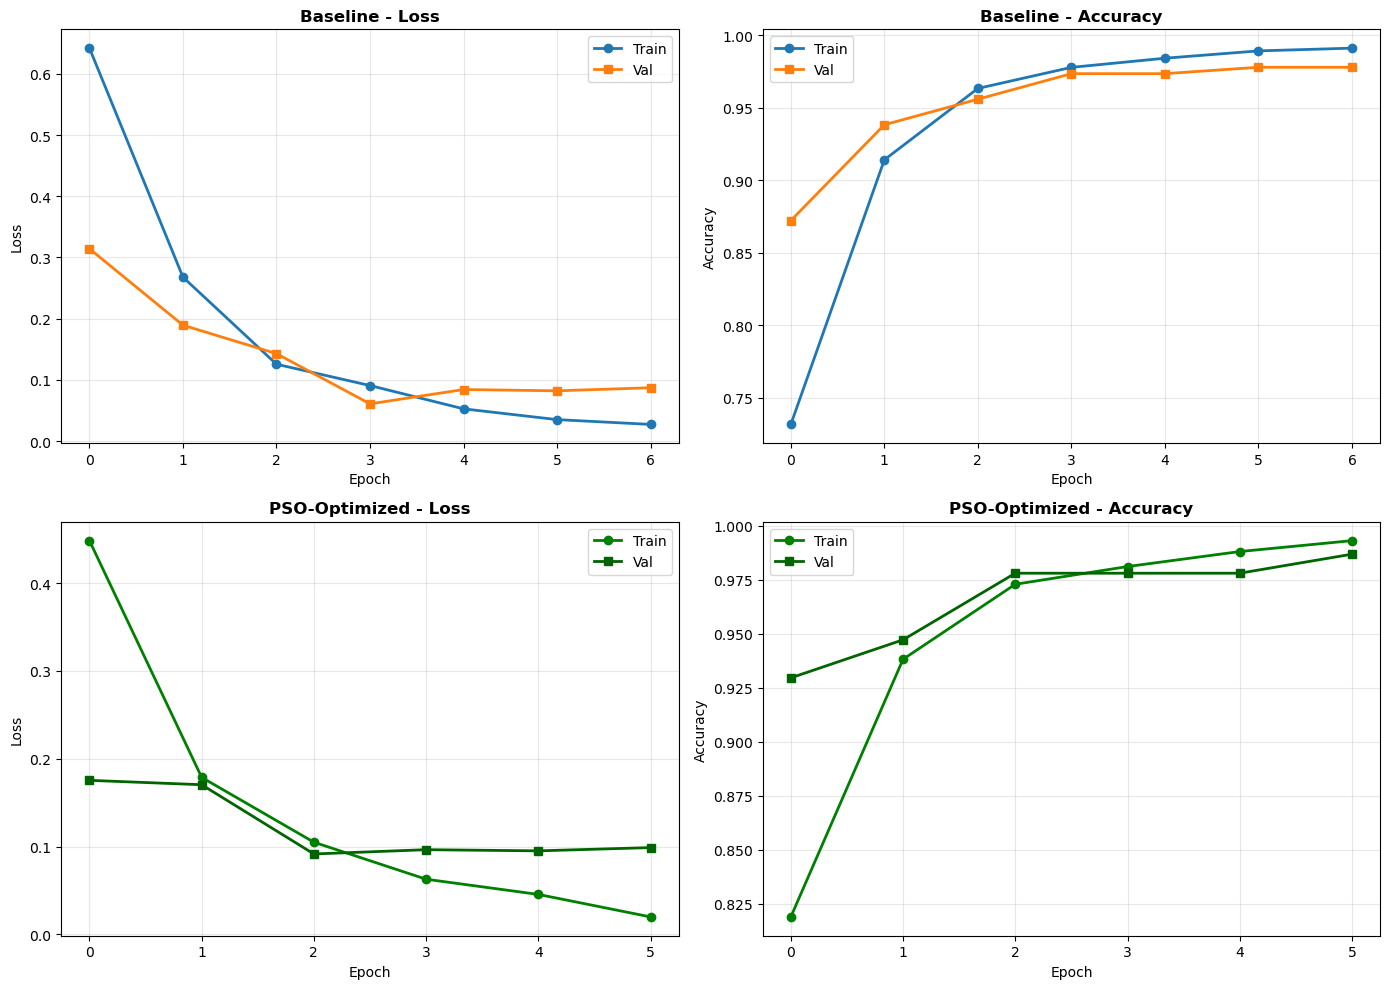

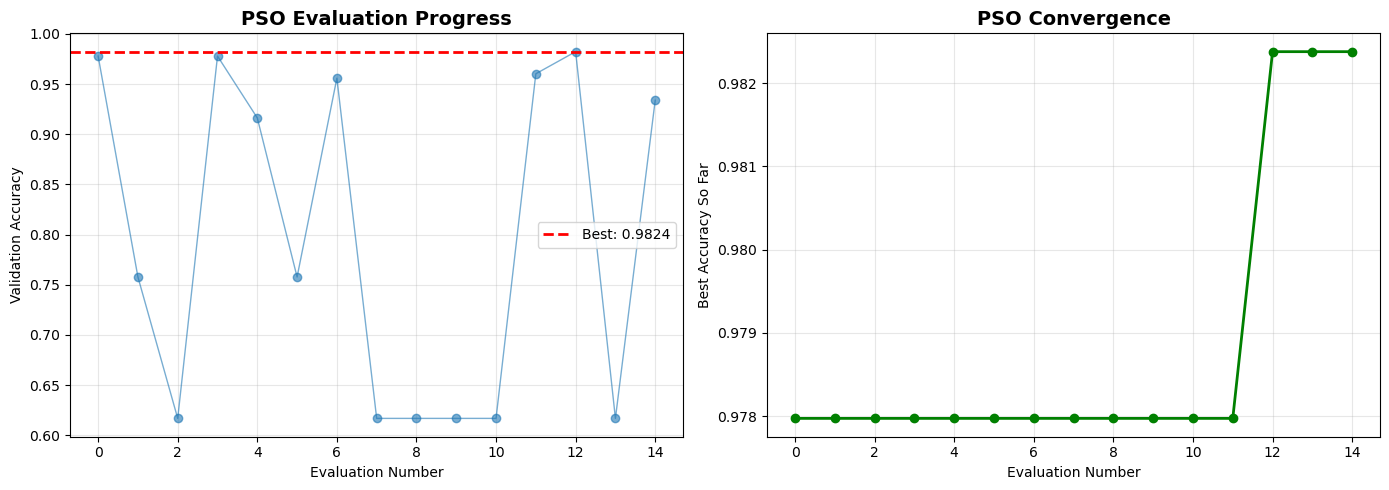


BASELINE - Classification Report
              precision    recall  f1-score   support

    Negative     0.9206    0.9508    0.9355        61
     Neutral     0.9925    0.9532    0.9725       278
    Positive     0.8780    0.9474    0.9114       114

    accuracy                         0.9514       453
   macro avg     0.9304    0.9505    0.9398       453
weighted avg     0.9540    0.9514    0.9521       453


PSO-OPTIMIZED - Classification Report
              precision    recall  f1-score   support

    Negative     0.9310    0.8852    0.9076        61
     Neutral     0.9927    0.9784    0.9855       278
    Positive     0.9008    0.9561    0.9277       114

    accuracy                         0.9603       453
   macro avg     0.9415    0.9399    0.9402       453
weighted avg     0.9613    0.9603    0.9605       453


✓ All evaluation complete!


In [17]:
print("="*60)
print("COMPREHENSIVE EVALUATION")
print("="*60)

# TABLE I: Optimal Hyperparameters
print("\nTABLE I: OPTIMAL HYPERPARAMETERS FOUND BY PSO")
print("="*60)
hyperparam_df = pd.DataFrame([{
    'Learning Rate': f"{best_params['learning_rate']:.2e}",
    'Dropout Rate': f"{best_params['dropout_rate']:.4f}",
    'Hidden Layer Size': best_params['hidden_size']
}])
print(hyperparam_df.to_string(index=False))

# TABLE II: Performance Comparison
print("\n\nTABLE II: PERFORMANCE COMPARISON")
print("="*60)
comparison_df = pd.DataFrame({
    'Model': ['DistilBERT Baseline', 'DistilBERT + PSO'],
    'Test Accuracy (%)': [
        baseline_results['test_accuracy'] * 100,
        final_results['test_accuracy'] * 100
    ],
    'Test Loss': [
        baseline_results['test_loss'],
        final_results['test_loss']
    ]
})
print(comparison_df.to_string(index=False))
improvement = (final_results['test_accuracy'] - baseline_results['test_accuracy']) * 100
print(f"\nImprovement: +{improvement:.2f} percentage points")
print("="*60)

# FIGURE 1: Model Comparison
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(comparison_df))
ax.bar(x, comparison_df['Test Accuracy (%)'], color=['steelblue', 'forestgreen'], alpha=0.8)
ax.set_ylabel('Test Accuracy (%)', fontsize=12)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'])
ax.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_df['Test Accuracy (%)']):
    ax.text(i, v + 1, f'{v:.2f}%', ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

# FIGURE 2: Confusion Matrices
label_names = ['Negative', 'Neutral', 'Positive']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

cm_baseline = confusion_matrix(baseline_results['test_labels'], baseline_results['test_predictions'])
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=label_names, yticklabels=label_names)
ax1.set_title('Baseline DistilBERT', fontsize=14, fontweight='bold')
ax1.set_ylabel('True Label')
ax1.set_xlabel('Predicted Label')

cm_final = confusion_matrix(final_results['test_labels'], final_results['test_predictions'])
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Greens', ax=ax2,
            xticklabels=label_names, yticklabels=label_names)
ax2.set_title('PSO-Optimized DistilBERT', fontsize=14, fontweight='bold')
ax2.set_ylabel('True Label')
ax2.set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# FIGURE 3: Training Curves Comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(baseline_results['history']['train_loss'], label='Train', marker='o', linewidth=2)
axes[0, 0].plot(baseline_results['history']['val_loss'], label='Val', marker='s', linewidth=2)
axes[0, 0].set_title('Baseline - Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(baseline_results['history']['train_acc'], label='Train', marker='o', linewidth=2)
axes[0, 1].plot(baseline_results['history']['val_acc'], label='Val', marker='s', linewidth=2)
axes[0, 1].set_title('Baseline - Accuracy', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(final_results['history']['train_loss'], label='Train', marker='o', linewidth=2, color='green')
axes[1, 0].plot(final_results['history']['val_loss'], label='Val', marker='s', linewidth=2, color='darkgreen')
axes[1, 0].set_title('PSO-Optimized - Loss', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(final_results['history']['train_acc'], label='Train', marker='o', linewidth=2, color='green')
axes[1, 1].plot(final_results['history']['val_acc'], label='Val', marker='s', linewidth=2, color='darkgreen')
axes[1, 1].set_title('PSO-Optimized - Accuracy', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# FIGURE 4: PSO Optimization Progress
history = pso_results['evaluation_history']
iterations = list(range(len(history)))
accuracies = [eval_data['val_accuracy'] for eval_data in history]
cumulative_best = np.maximum.accumulate(accuracies)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(iterations, accuracies, marker='o', alpha=0.6, linewidth=1)
ax1.axhline(y=best_acc, color='r', linestyle='--', label=f'Best: {best_acc:.4f}', linewidth=2)
ax1.set_xlabel('Evaluation Number')
ax1.set_ylabel('Validation Accuracy')
ax1.set_title('PSO Evaluation Progress', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(iterations, cumulative_best, marker='o', color='green', linewidth=2)
ax2.set_xlabel('Evaluation Number')
ax2.set_ylabel('Best Accuracy So Far')
ax2.set_title('PSO Convergence', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Classification Reports
print("\n" + "="*60)
print("BASELINE - Classification Report")
print("="*60)
print(classification_report(baseline_results['test_labels'], baseline_results['test_predictions'],
                          target_names=label_names, digits=4))

print("\n" + "="*60)
print("PSO-OPTIMIZED - Classification Report")
print("="*60)
print(classification_report(final_results['test_labels'], final_results['test_predictions'],
                          target_names=label_names, digits=4))

print("\n✓ All evaluation complete!")

## Cell 11: Save All Results

In [18]:
# Save all results for later use or paper
import pickle

# Save baseline results
with open('baseline_results.pkl', 'wb') as f:
    pickle.dump(baseline_results, f)

# Save PSO results
with open('pso_results.pkl', 'wb') as f:
    pickle.dump(pso_results, f)

# Save final results
with open('final_results.pkl', 'wb') as f:
    pickle.dump(final_results, f)

# Save comparison data for paper
with open('comparison_tables.pkl', 'wb') as f:
    pickle.dump({
        'hyperparameters': hyperparam_df,
        'comparison': comparison_df
    }, f)

print("✓ All results saved!")
print("\nSaved files:")
print("  - baseline_results.pkl")
print("  - pso_results.pkl")
print("  - final_results.pkl")
print("  - comparison_tables.pkl")

print("\n" + "="*60)
print("PROJECT COMPLETE!")
print("="*60)
print(f"\nFinal Results Summary:")
print(f"  Baseline Accuracy: {baseline_results['test_accuracy']*100:.2f}%")
print(f"  PSO-Optimized Accuracy: {final_results['test_accuracy']*100:.2f}%")
print(f"  Improvement: +{improvement:.2f} percentage points")
print(f"\nOptimal Hyperparameters:")
print(f"  Learning Rate: {best_params['learning_rate']:.2e}")
print(f"  Dropout Rate: {best_params['dropout_rate']:.4f}")
print(f"  Hidden Size: {best_params['hidden_size']}")
print("\nNext steps: Use these results to write your IEEE paper!")

✓ All results saved!

Saved files:
  - baseline_results.pkl
  - pso_results.pkl
  - final_results.pkl
  - comparison_tables.pkl

PROJECT COMPLETE!

Final Results Summary:
  Baseline Accuracy: 95.14%
  PSO-Optimized Accuracy: 96.03%
  Improvement: +0.88 percentage points

Optimal Hyperparameters:
  Learning Rate: 1.07e-04
  Dropout Rate: 0.3118
  Hidden Size: 417

Next steps: Use these results to write your IEEE paper!
